In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from ignite.metrics import Accuracy, Precision, Recall 
import pandas as pd
import re
from nltk.corpus import stopwords
import gc

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
def clean(doc, stop_words):
    '''Return alphabetic-only version of the given doc'''
    
    match = r'(?i)[^A-Z]' # match a non-alphabetic symbol
    alphabetic_only = re.sub(match, ' ', doc)
    terms = alphabetic_only.split()
    no_stop_words = [term for term in terms if term not in stop_words]
    clean_doc = ' '.join(no_stop_words)
    
    return clean_doc.lower()

In [4]:
stop_words = stopwords.words('english')

In [5]:
df['comment_text'] = df['comment_text'].apply(lambda text: clean(text, stop_words))
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches background colour i seemingly...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i really trying edit war it guy consta...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i make real suggestions improvement i won...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir hero any chance remember page,0,0,0,0,0,0


In [6]:
def get_all_terms(corpus):
    '''Return a list of all (including non-unique) terms in the corpus'''
    
    terms_in_corpus = []
    for doc in corpus:
        terms_in_corpus.extend(doc.split())
        
    return terms_in_corpus

In [7]:
terms_in_corpus = get_all_terms(df['comment_text'].values)

In [8]:
terms_in_corpus[:5]

['explanation', 'why', 'edits', 'made', 'username']

In [9]:
def count(iterable, placeholder=None):
    '''Return a dict.
    
    Keys are unique objects from an iterable.
    
    Values are their amount in the whole iterable
    '''
    
    if not iterable:
        return {placeholder: 0} # prevent empty dictionaries
    
    counter = {}
    for item in iterable:
        if item in counter:
            counter[item] += 1
        else:
            counter[item] = 1
            
    return counter

In [10]:
terms_dict = count(terms_in_corpus, placeholder='wikipedia')
terms_s = pd.Series(terms_dict)
terms_s.sort_values(inplace=True, ascending=False)

In [11]:
terms_s[:5]

i            224568
article       57738
wikipedia     48625
the           47823
page          46542
dtype: int64

In [12]:
# select most popluar words to reduce bag size
n_popular = 5000
top_terms = terms_s.index.values[:n_popular]

In [14]:
def create_bag(corpus, top_terms):
    '''Return a dict.
    Keys are corpus index.
    Values are their bag-of-words representation
    '''
    
    docs = {}
    for idx, doc in enumerate(corpus):
        doc_terms = doc.split()
        intesect_top_terms = [term for term in doc_terms if term in top_terms]
        docs[idx] = count(intesect_top_terms, placeholder='wikipedia')
    
    return docs

In [15]:
bag_of_words_dict = create_bag(df['comment_text'].values, top_terms)

In [16]:
bag_of_words_df = pd.DataFrame.from_dict(bag_of_words_dict, orient='index', dtype=np.int32)
bag_of_words_df = bag_of_words_df.fillna(0).astype(np.int32).sort_index()
bag_of_words_df.head()

,explanation,why,edits,made,username,hardcore,fan,reverted,they,gas,...,deneid,marcolfuck,boymamas,nikko,fucksex,bastered,fack,criminalwar,youbollocks,aidsaids
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# bag_of_words_df.to_hdf('bag_of_words.h5', 'df')

In [18]:
# bag_of_words_df = pd.read_hdf('bag_of_words.h5', 'df')

In [19]:
def tf_idf(bag_of_words):
    '''Compute a tf-idf transformation for a bag of words'''
    
    doc_len = len(bag_of_words[0])
    D = len(bag_of_words)

    # idf
    idf = []
    for term in bag_of_words.transpose():
        idf.append(np.log(D / np.count_nonzero(term)))
    idf = np.array(idf)

    # tf-idf
    tfidf = []
    for doc in bag_of_words:
        tf = []
        for term in doc:
            tf.append(term / doc_len)
        tfidf.append(np.array(tf) * idf)
        
    return np.array(tfidf)

In [20]:
bag_of_words_tf_idf = tf_idf(bag_of_words_df.values)

In [21]:
del bag_of_words_df
gc.collect()

100

In [22]:
# np.save('bag_of_words_tf_idf.npy', bag_of_words_tf_idf)

In [23]:
dataset = np.array([[data, target] for data, target in zip(bag_of_words_tf_idf, df['toxic'].values)], dtype=object)
dataset = dataset[np.random.permutation(len(dataset))]

In [24]:
del bag_of_words_tf_idf
del df
gc.collect()

20

In [25]:
class Toxic(Dataset):
    
    def __init__(self, dataset, phase='train'):
        
        self.dataset = dataset
        self.phase = phase

        
        if self.phase == 'train':
            start = 0
            end = int(0.5 * len(dataset.data))
        elif self.phase == 'val':
            start = int(0.5 * len(dataset.data))
            end = int(0.75 * len(dataset.data))
        elif self.phase == 'test':
            start = int(0.75 * len(dataset.data))
            end = len(dataset.data)
        else:
            start = 0
            end = len(dataset.data)
            
        self.data = self.dataset[start:end, 0]
        self.targets = self.dataset[start:end, 1]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.data[idx].astype(np.float32)
        target = self.targets[idx].astype(np.float32)
            
        return data, target

In [26]:
train_set = Toxic(dataset, phase='train')
val_set = Toxic(dataset, phase='val')
test_set = Toxic(dataset, phase='test')

In [27]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10

In [28]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [29]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5000, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.2)
        
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.bn2 = nn.BatchNorm1d(num_features=32)


        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid((self.fc3(x)))
    
        return x

In [30]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.BCELoss()
device = 'cuda'
model.to(device)

Net(
  (fc1): Linear(in_features=5000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [31]:
total_progress = tqdm(total=num_epochs, desc='Total progress')
epoch_losses = []
casual_losses = []

for epoch in range(num_epochs):
    model.train()
    
    epoch_progress = tqdm(total=len(train_loader), desc=f'Epoch {epoch}', leave=False)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        target = target.unsqueeze(1)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_progress.update()
        casual_losses.append(loss.item())
    
    model.eval()
    val_losses = []
    for batch_idx, (data, target) in enumerate(val_loader):
        data = data.to(device)
        target = target.to(device)
        target = target.unsqueeze(1)
        output = model(data)
        loss = loss_fn(output, target)
        val_losses.append(loss.item())
    
    mean_val_loss = np.mean(val_losses)
    epoch_losses.append(mean_val_loss)
    if min(epoch_losses) == mean_val_loss:
        torch.save(model, 'min_val_loss.pt')
        
    scheduler.step(mean_val_loss)
    
    print(f"Val loss {epoch} : {np.mean(val_losses)}")
    
    epoch_progress.close()
    total_progress.update()

total_progress.close()

Val loss 0 : 0.3843914763919812


Val loss 1 : 0.23660024696454682


Val loss 2 : 0.2931449275759572


Val loss 3 : 0.21030549672764592


Val loss 4 : 0.24949466479522472


Val loss 5 : 0.20016351349968478


Val loss 6 : 0.20790720322343378


Val loss 7 : 0.1761354447044462


Val loss 8 : 0.17736765999218512


Val loss 9 : 0.16845868699963606



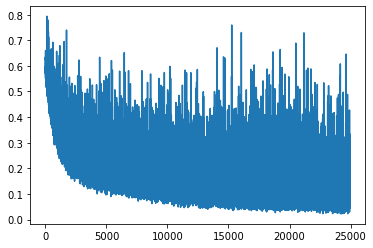

In [32]:
plt.plot(casual_losses)

In [40]:
best_weights_model = torch.load('min_val_loss.pt')
best_weights_model.to(device)

Net(
  (fc1): Linear(in_features=5000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [41]:
accuracy = Accuracy()
accuracy.reset()

for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = best_weights_model(data)
        accuracy.update((output.round(), target.unsqueeze(1)))
        
print(accuracy.compute())

0.9497405559872659
